In [132]:
import sys, os
print(sys.executable)
print(os.getcwd())

C:\Users\chenr\miniforge3\envs\astropy\python.exe
C:\Users\chenr\OneDrive\Desktop\phys-134-proj\lco_data-20251202-36


In [133]:
rootfolder=os.getcwd().replace('\\','/')
print(rootfolder)

C:/Users/chenr/OneDrive/Desktop/phys-134-proj/lco_data-20251202-36


In [134]:
os.chdir(f"{rootfolder}/lco_data-20251202-36")
os.getcwd()

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:/Users/chenr/OneDrive/Desktop/phys-134-proj/lco_data-20251202-36/lco_data-20251202-36'

In [135]:
import pickle 
with open('merged_data.pkl', 'rb') as f:
    merged_data = pickle.load(f)
    

In [136]:
file_list=os.listdir(".")

# filter to only .fits files
file_list=[f for f in file_list if f.endswith('.fits') and f.startswith('2025')]
print(file_list)

['2025-11-25-h02-m00-s14-ms936-tfn.fits', '2025-11-25-h05-m00-s13-ms688-lsc.fits', '2025-11-25-h05-m36-s42-ms454-lsc.fits', '2025-11-25-h06-m06-s14-ms909-lsc.fits', '2025-11-25-h07-m45-s12-ms840-elp.fits', '2025-11-25-h08-m30-s09-ms718-elp.fits', '2025-11-25-h09-m06-s12-ms841-elp.fits', '2025-11-25-h10-m06-s14-ms367-elp.fits', '2025-11-25-h11-m06-s18-ms072-elp.fits', '2025-11-25-h12-m47-s39-ms526-ogg.fits', '2025-11-25-h13-m06-s13-ms287-ogg.fits', '2025-11-25-h14-m06-s15-ms196-ogg.fits', '2025-11-25-h23-m02-s40-ms929-tfn.fits', '2025-11-25-h23-m35-s17-ms210-cpt.fits', '2025-11-26-h00-m55-s17-ms907-tfn.fits', '2025-11-26-h01-m55-s17-ms940-tfn.fits', '2025-11-26-h02-m10-s07-ms425-tfn.fits', '2025-11-26-h03-m06-s19-ms581-tfn.fits', '2025-11-26-h04-m06-s16-ms133-tfn.fits', '2025-11-26-h05-m35-s14-ms393-lsc.fits', '2025-11-26-h06-m06-s06-ms084-lsc.fits', '2025-11-26-h07-m59-s44-ms591-elp.fits', '2025-11-26-h08-m06-s06-ms512-elp.fits', '2025-11-26-h11-m06-s14-ms445-ogg.fits', '2025-11-26-h12

In [137]:
# dict of dicts of arrays
#     merged_data[observation file]={
#         'icrs': {
#             'ra': catalog_data[key]['RA'],
#             'dec': catalog_data[key]['Dec']
#         },
#         'image': {
#             'x': region_data[key]['x'],
#             'y': region_data[key]['y']
#         }
#     }
# Data is ordered and balanced across and within all observation files
#

# A: GAUSSIAN FITING
# For each observation file:
#     Load entire image array
#     For each reference star in merged_data: (from pickle): 
#       Use function to fit 2D Gaussian on that cutout to get centroid and sigma values (x_fit, y_fit, sigma_fit)
#     New arrays: xs_fit, ys_fit, sigmas_fit for all reference stars in this observation file.
#       Check that its length matches number of reference stars.
#     Store in merged_data under this observation file's key as new dict entry 'image_fit'

# new merged_data structure:
#     merged_data[observation file]={
#         'icrs': {
#             'ra': catalog_data[key]['RA'],
#             'dec': catalog_data[key]['Dec']
#         },
#         'image': {
#             'x': region_data[key]['x'],
#             'y': region_data[key]['y']
#         },
#         'image_fit': {
#             'xs_fit': array of x centroids,
#             'ys_fit': array of y centroids,
#             'sigmas_fit': array of sigma values
#         }
#     }

#B: APERTURE PHOTOMETRY
#     Designate apertures and annuli based on x_cen, y_cen, where app_rad=7*sigma_xy, ann_rad_in=9*sigma_xy, ann_rad_out=11*sigma_xy

#     Calculate total flux subtracted by background, using 3-sigma medium clip on annulus pixels to get background level
#     Store flux in array whose index matches reference star index in region_data
#
#     Generate an tile plot for this observation file, showing each reference star with aperture and annulus overlaid
# At end, save all flux arrays to file using pickle

# Image processing function (debugging)
def imageprocessing(arr, min_clip=-100, max_clip=5000, a=1000, contrast=3.86, bias=0.442):
    clipped = np.clip(arr, min_clip, max_clip)
    norm = (clipped - min_clip) / (max_clip - min_clip)
    log = np.log(1 + a*norm) / np.log(a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data


In [ ]:
center= 20

In [ ]:
# A: GAUSSIAN FITING
# For each observation file:
#     Load entire image array
#     For each reference star in merged_data: (from pickle): 
#       Use function to fit 2D Gaussian on that cutout to get centroid and sigma values (x_fit, y_fit, sigma_fit)
#     New arrays: xs_fit, ys_fit, sigmas_fit for all reference stars in this observation file.
#       Check that its length matches number of reference stars.
#     Store in merged_data under this observation file's key as new dict entry 'image_fit'


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
for idx, filename in enumerate(file_list):
    print(f"Fitting Gaussians for file {idx+1} of {len(file_list)}: {filename}")
    hdul = fits.open(filename)
    pixel_array = hdul['SCI'].data
    hdul.close()
    #Gaussian2D model: amplitude, x_mean, y_mean, x_stddev, y_stddev, theta | None, cov_matrix | None
    # we'll just use the larger stdev and assume symmetric 2d gaussian later
    #using lmlsqfitter since we want a greedy fit since we're quite confident with initial guesses
    #x_mean and y_mean are the centroid positions, we already have good estimates
    
    # starting with an amplitude estimate
    # amplitude can be estimated as max pixel value in cutout - median pixel value in cutout
    # lets slice a 31 pixel cutout (+-15 pixels square) around each reference star centroid's rounded image x,y
    
    #within frame !!!!
    #array of 2d arrays, given by +- 15 pixels from center, where center is rounded x,y from merged_data
    #1 per reference star
    offset = 15
    
    # +1 on ends since ends are exlusive in python slicing
    cutouts = [pixel_array[round(y)-offset:round(y)+offset+1, round(x)-offset:round(x)+offset+1]
               for x,y
               in zip(merged_data[filename]['image']['x'], merged_data[filename]['image']['y'])]
    
    amp_guesses = [np.max(cutout) - np.median(cutout) for cutout in cutouts]
    x0_guesses = merged_data[filename]['image']['x']
    y0_guesses = merged_data[filename]['image']['y']
    #sigma guess is just 2 for now
    x_fits = []
    y_fits = []
    sigmas_fit = []
    
    #perform fit
    for idx_cutout, cutout in enumerate(cutouts):
        amp_guess = amp_guesses[idx_cutout]
        x0_guess = offset  # since cutout is centered around star, x0 and y0 are at center of cutout
        y0_guess = offset
        sigma_guess = 2.0
        
        gauss_init = models.Gaussian2D(amplitude=amp_guess,
                                       x_mean=x0_guess,
                                       y_mean=y0_guess,
                                       x_stddev=sigma_guess,
                                       y_stddev=sigma_guess)
        
        fit_p = fitting.LevMarLSQFitter()
        y_indices, x_indices = np.mgrid[0:cutout.shape[0], 0:cutout.shape[1]]   
        gauss_fit = fit_p(gauss_init, x_indices, y_indices, cutout)
        
        # since the fits are on a cutout, the image adjustment is: fit + rounded original center - offset
        x_fits.append(gauss_fit.x_mean.value + round(merged_data[filename]['image']['x'][idx_cutout]) - offset)
        y_fits.append(gauss_fit.y_mean.value + round(merged_data[filename]['image']['y'][idx_cutout]) - offset)
        sigmas_fit.append((gauss_fit.x_stddev.value + gauss_fit.y_stddev.value) / 2.0)
        
    merged_data[filename]['image_fit'] = {
        'xs_fit': np.array(x_fits),
        'ys_fit': np.array(y_fits),
        'sigmas_fit': np.array(sigmas_fit)
    }

Fitting Gaussians for file 1 of 36: 2025-11-25-h02-m00-s14-ms936-tfn.fits
Fitting Gaussians for file 2 of 36: 2025-11-25-h05-m00-s13-ms688-lsc.fits
Fitting Gaussians for file 3 of 36: 2025-11-25-h05-m36-s42-ms454-lsc.fits
Fitting Gaussians for file 4 of 36: 2025-11-25-h06-m06-s14-ms909-lsc.fits
Fitting Gaussians for file 5 of 36: 2025-11-25-h07-m45-s12-ms840-elp.fits
Fitting Gaussians for file 6 of 36: 2025-11-25-h08-m30-s09-ms718-elp.fits
Fitting Gaussians for file 7 of 36: 2025-11-25-h09-m06-s12-ms841-elp.fits
Fitting Gaussians for file 8 of 36: 2025-11-25-h10-m06-s14-ms367-elp.fits
Fitting Gaussians for file 9 of 36: 2025-11-25-h11-m06-s18-ms072-elp.fits
Fitting Gaussians for file 10 of 36: 2025-11-25-h12-m47-s39-ms526-ogg.fits
Fitting Gaussians for file 11 of 36: 2025-11-25-h13-m06-s13-ms287-ogg.fits
Fitting Gaussians for file 12 of 36: 2025-11-25-h14-m06-s15-ms196-ogg.fits
Fitting Gaussians for file 13 of 36: 2025-11-25-h23-m02-s40-ms929-tfn.fits


Fitting Gaussians for file 14 of 36: 2025-11-25-h23-m35-s17-ms210-cpt.fits
Fitting Gaussians for file 15 of 36: 2025-11-26-h00-m55-s17-ms907-tfn.fits
Fitting Gaussians for file 16 of 36: 2025-11-26-h01-m55-s17-ms940-tfn.fits
Fitting Gaussians for file 17 of 36: 2025-11-26-h02-m10-s07-ms425-tfn.fits
Fitting Gaussians for file 18 of 36: 2025-11-26-h03-m06-s19-ms581-tfn.fits
Fitting Gaussians for file 19 of 36: 2025-11-26-h04-m06-s16-ms133-tfn.fits
Fitting Gaussians for file 20 of 36: 2025-11-26-h05-m35-s14-ms393-lsc.fits
Fitting Gaussians for file 21 of 36: 2025-11-26-h06-m06-s06-ms084-lsc.fits
Fitting Gaussians for file 22 of 36: 2025-11-26-h07-m59-s44-ms591-elp.fits
Fitting Gaussians for file 23 of 36: 2025-11-26-h08-m06-s06-ms512-elp.fits
Fitting Gaussians for file 24 of 36: 2025-11-26-h11-m06-s14-ms445-ogg.fits
Fitting Gaussians for file 25 of 36: 2025-11-26-h12-m06-s12-ms274-ogg.fits
Fitting Gaussians for file 26 of 36: 2025-11-26-h13-m06-s14-ms392-ogg.fits
Fitting Gaussians for fil

### Debugging

2025-11-25-h23-m35-s17-ms210-cpt.fits


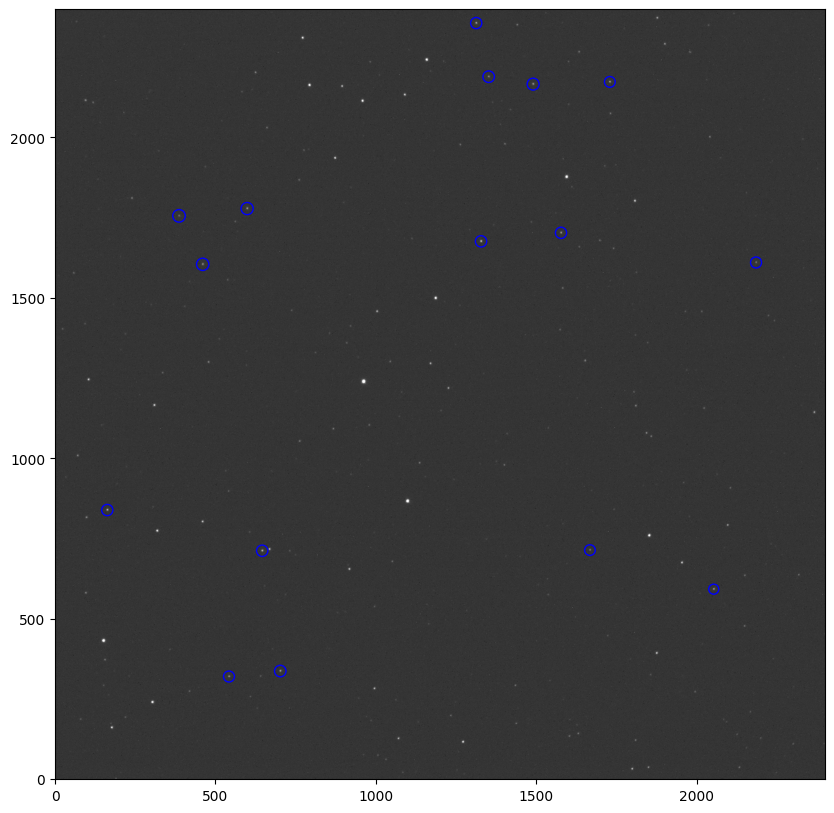

In [ ]:
# appears to be an issue on frame 14.
# draw image and overplot an X at each fitted centroid and a circle with r= sigma*3

#imageprocessing
# --- IGNORE ---
idx = 13
#file name print
print(file_list[idx])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
hdul = fits.open(file_list[idx])
# --- IGNORE ---
pixel_array = hdul['SCI'].data
hdul.close()
processed_image = imageprocessing(pixel_array)
ax.imshow(processed_image, cmap='gray', origin='lower')
for idx_star in range(len(merged_data[file_list[idx]]['image']['x'])):
    x_fit = merged_data[file_list[idx]]['image_fit']['xs_fit'][idx_star]
    y_fit = merged_data[file_list[idx]]['image_fit']['ys_fit'][idx_star]
    sigma_fit = merged_data[file_list[idx]]['image_fit']['sigmas_fit'][idx_star]
    # ax.plot(x_fit, y_fit, marker='x', color='red', markersize=10)
    circle = plt.Circle((x_fit, y_fit), radius=sigma_fit*10, color='blue', fill=False)
    ax.add_patch(circle)
plt.show()

In [ ]:
# example
merged_data[file_list[0]]['image_fit']['sigmas_fit']


array([1.03077514, 1.00651571, 1.01094765, 1.04571097, 0.99655584,
       1.0536631 , 0.96771333, 0.99480954, 0.96752304, 1.04617308,
       0.95677944, 0.97876514, 0.97860659, 1.00952627, 1.04701747,
       0.98717925])

looks fine to me

# Aperture Photometry

#### Test Run

Performing aperture photometry for file 1 of 36: 2025-11-25-h02-m00-s14-ms936-tfn.fits


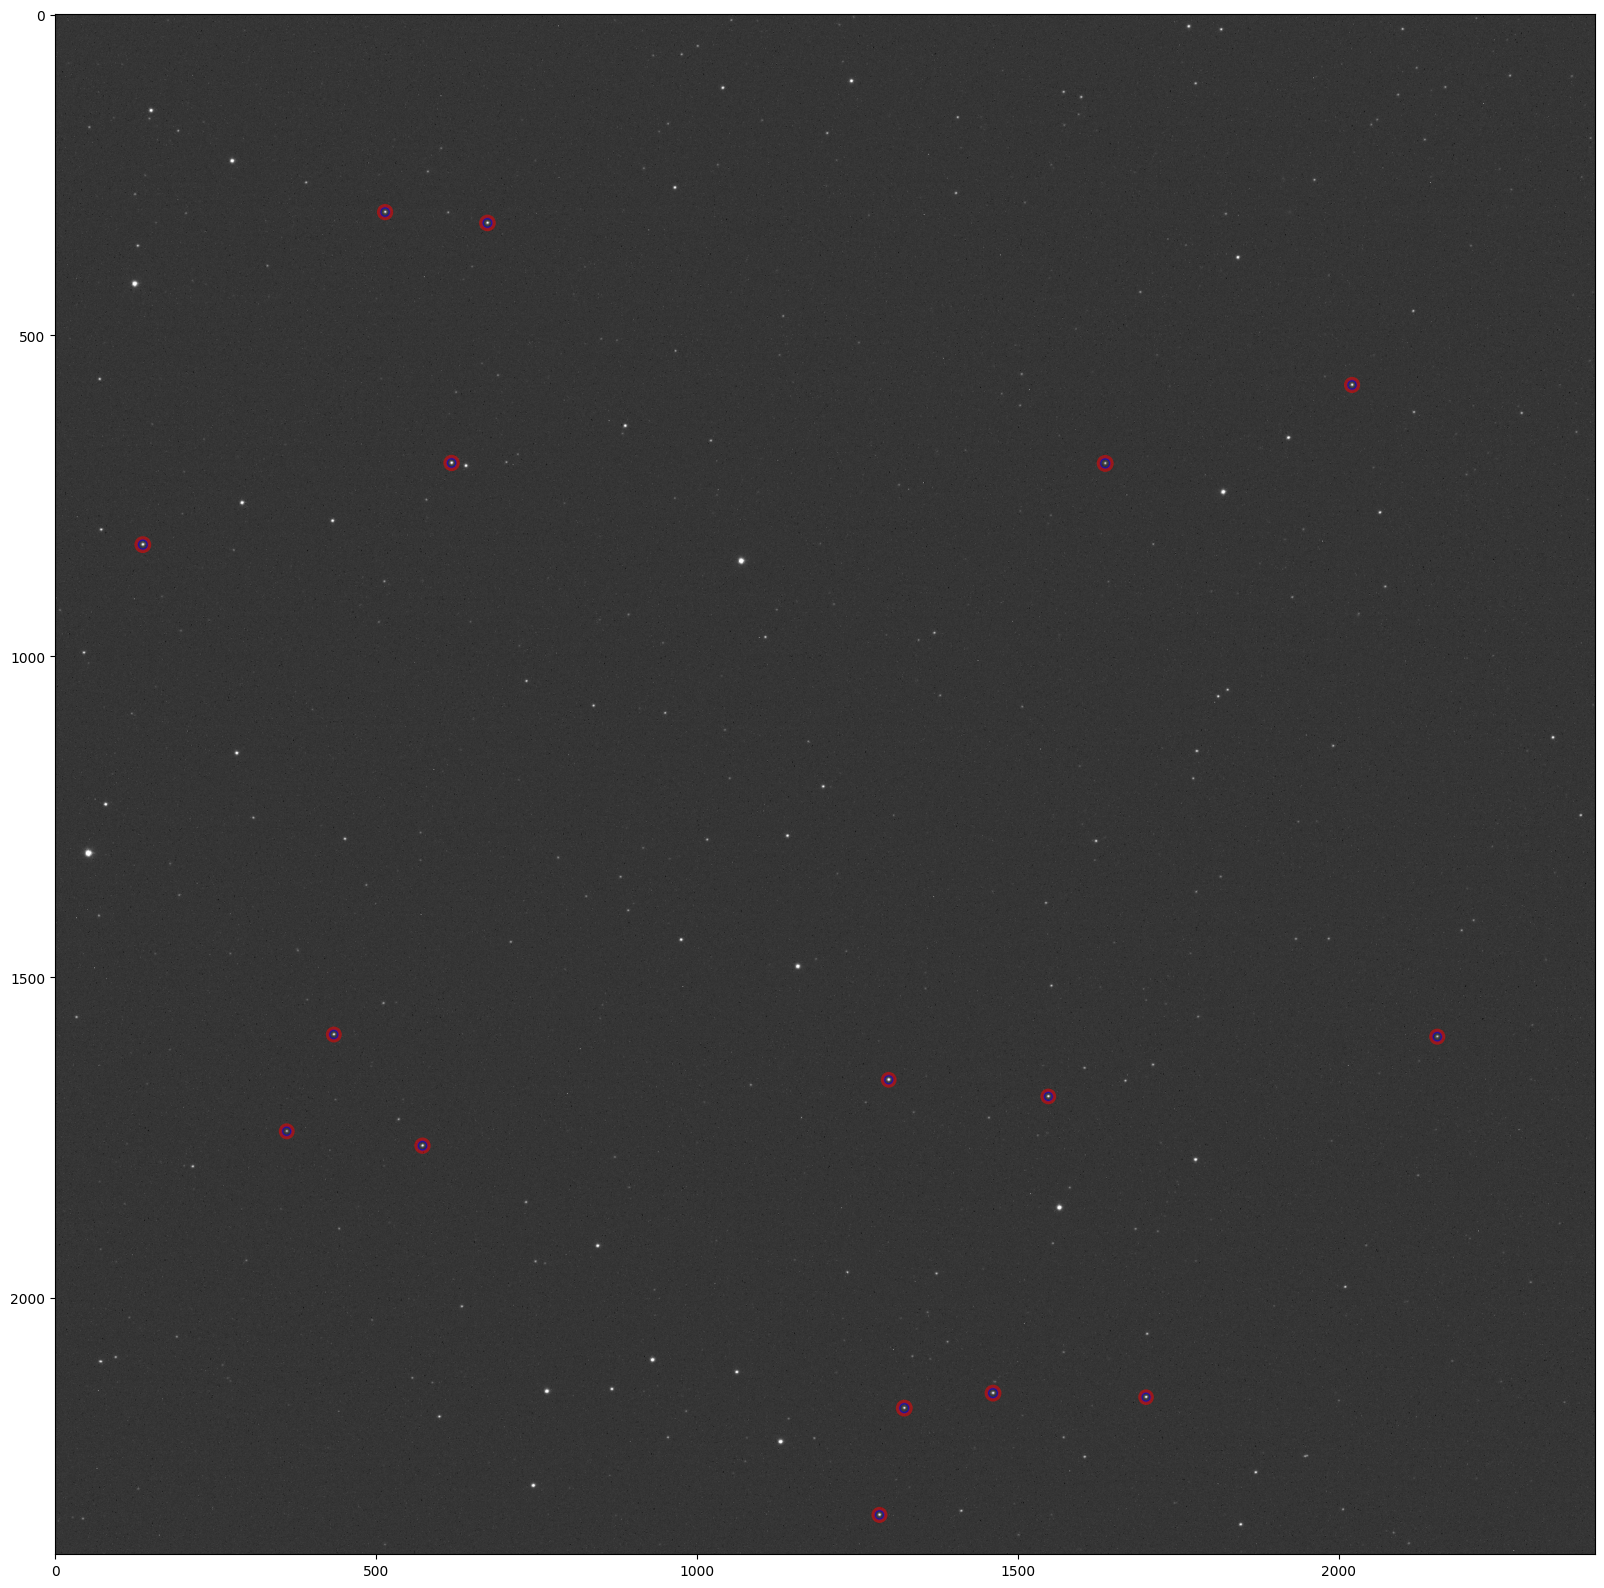

[np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan)]

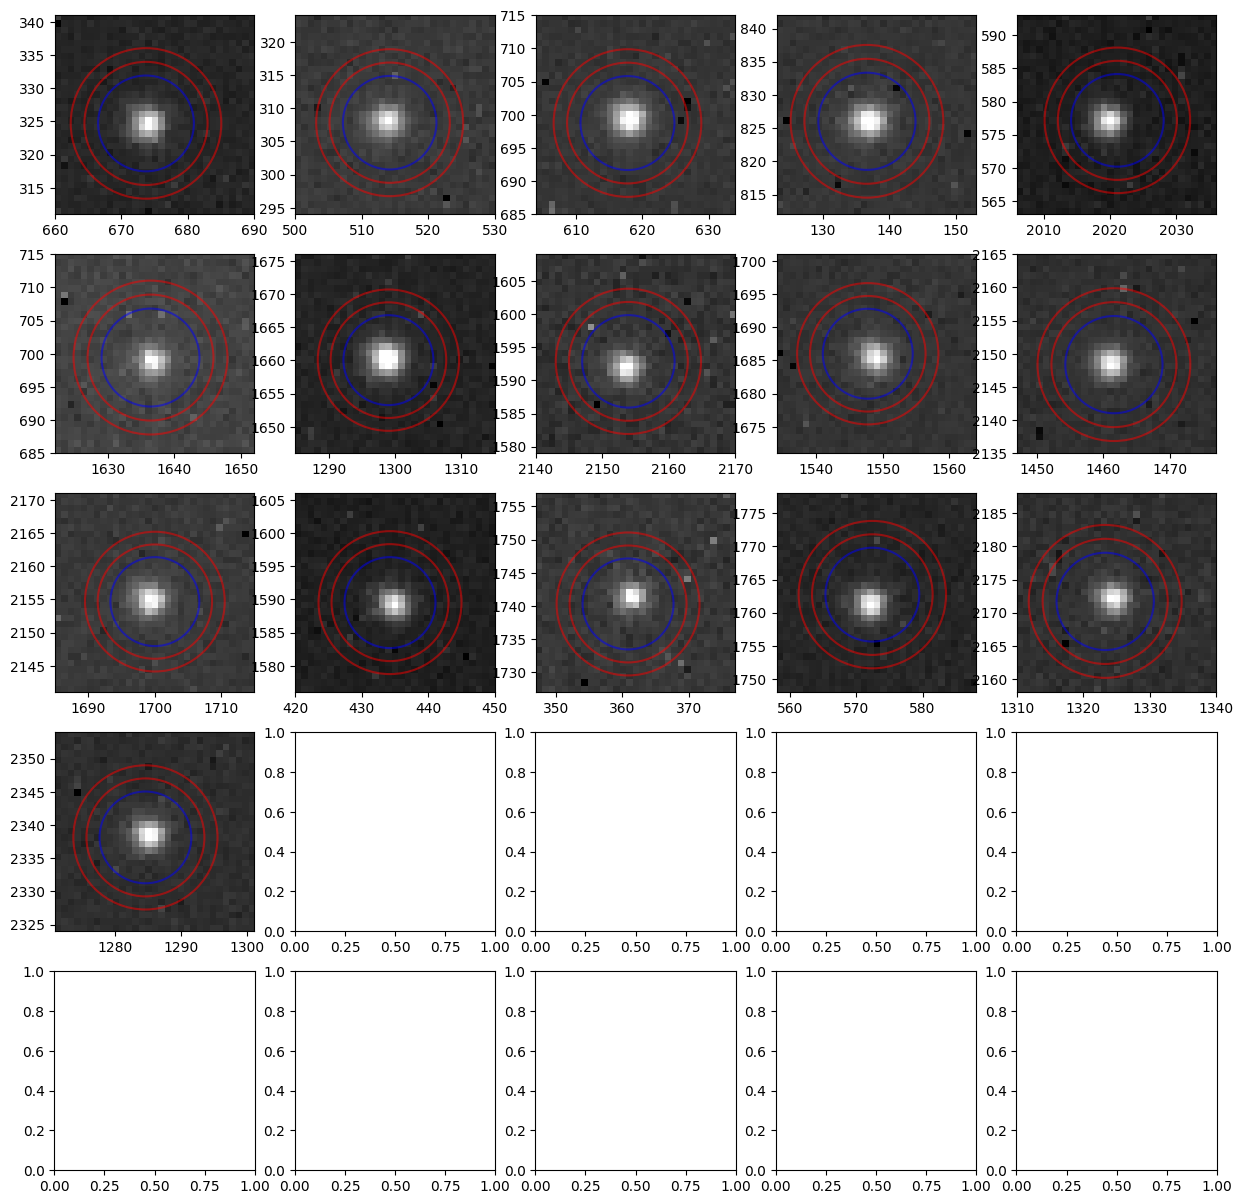

In [ ]:
# test run on 1
index = 0
file = file_list[0]
    
print(f"Performing aperture photometry for file {index+1} of {len(file_list)}: {file}")
hdul = fits.open(file)
pixel_array = hdul['SCI'].data
hdul.close()

positions = [(x, y) for x, y in zip(merged_data[file]['image_fit']['xs_fit'],
                                        merged_data[file]['image_fit']['ys_fit'])]
sigmas = merged_data[file]['image_fit']['sigmas_fit']
apertures = [CircularAperture(pos, r=7*sigma) for pos, sigma in zip(positions, sigmas)]
annulus_apertures = [CircularAnnulus(pos, r_in=9*sigma, r_out=11*sigma) for pos, sigma in zip(positions, sigmas)]

#draw image and overplot apertures and annuli
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
processed_image = imageprocessing(pixel_array)
ax.imshow(processed_image, cmap='gray')
for aperture in apertures:
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)
for annulus_aperture in annulus_apertures:
    annulus_aperture.plot(ax=ax, color='red', lw=1.5, alpha=0.5)
plt.show()




In [ ]:
sigclip = SigmaClip(sigma=3.0, maxiters=10)

aper_stats_list = [ApertureStats(pixel_array, aperture=ap, sigma_clip=None) 
                    for ap in apertures]

annulus_stats_list = [ApertureStats(pixel_array, aperture=ann_ap, sigma_clip=sigclip) 
                        for  ann_ap in annulus_apertures]

total_anulus_list = [annulus_stats.median * aper_stats.sum_aper_area.value for annulus_stats, aper_stats in zip(annulus_stats_list, aper_stats_list)]

apersum_subanulus_list  = [aper_stats.sum - total_anulus 
                            for aper_stats, total_anulus in zip(aper_stats_list, total_anulus_list)]

apersum_subanulus_list

[np.float64(4106.844601942044),
 np.float64(3147.376803245263),
 np.float64(5223.641260861766),
 np.float64(5300.556094428074),
 np.float64(3587.9616188172768),
 np.float64(2205.210267187871),
 np.float64(6125.185174991293),
 np.float64(2062.0876692048614),
 np.float64(3688.893831975441),
 np.float64(3838.7079659062624),
 np.float64(3564.815697552468),
 np.float64(3262.4614068067526),
 np.float64(1786.0137059822364),
 np.float64(3800.757557535755),
 np.float64(2840.8898100753963),
 np.float64(4204.457187399697)]

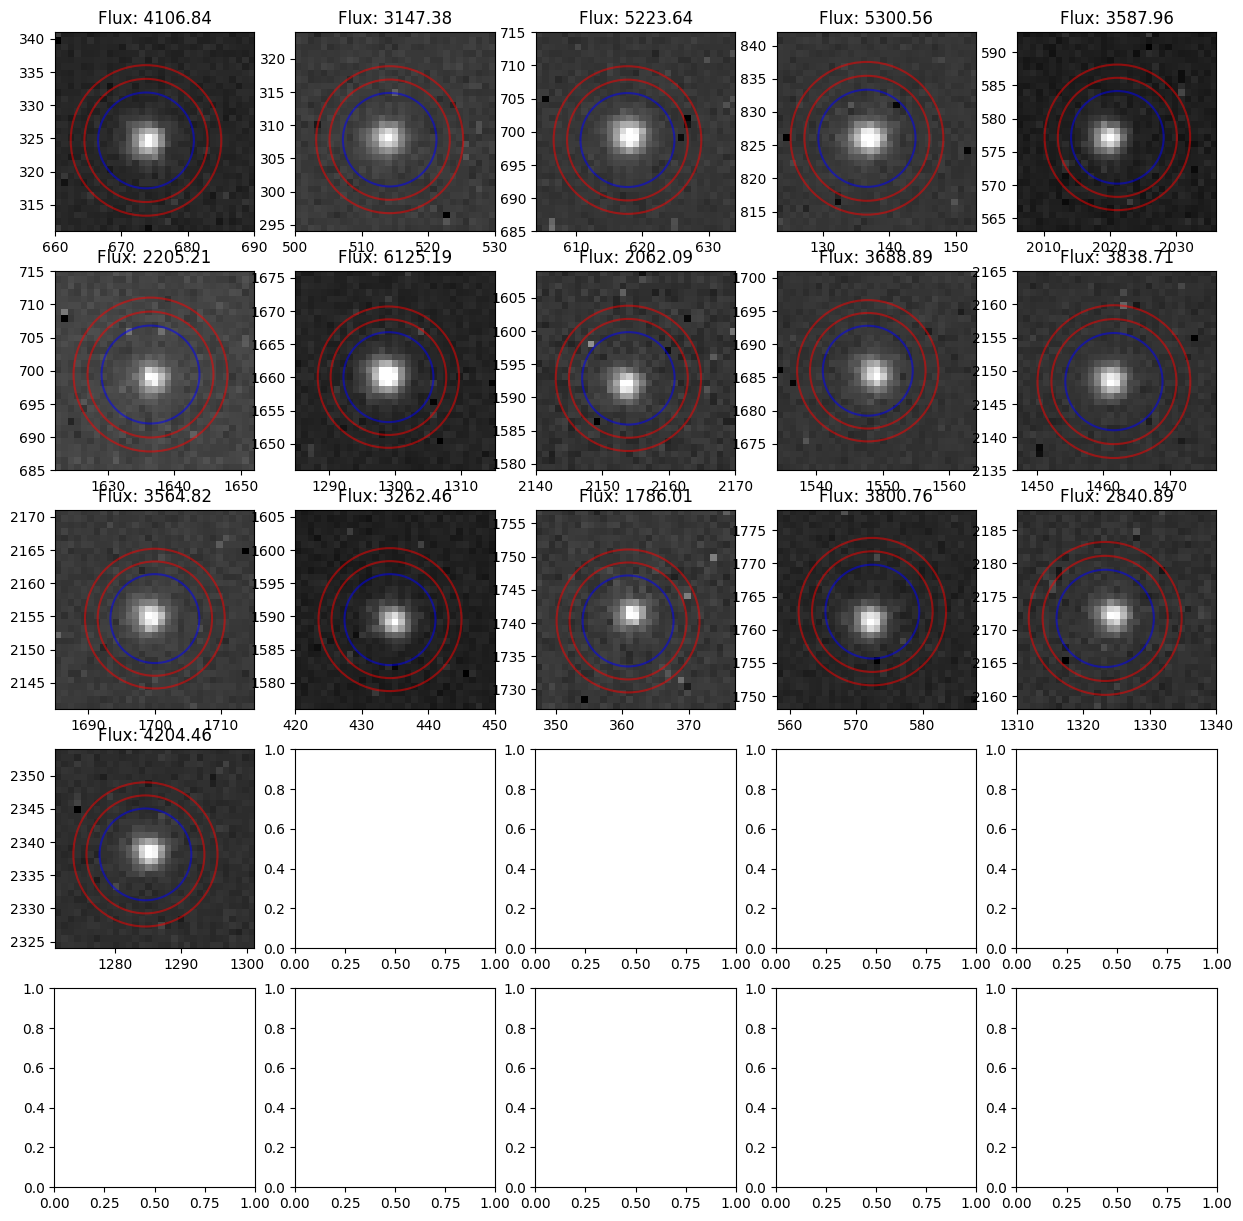

In [ ]:
#2nd tile plots of cutouts of each reference star with aperture and annulus overplotted
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

indexx = 0
for ax, cutout, aperture, ann_ap in zip(axes.flatten(), cutouts, apertures, annulus_apertures):
    processed_cutout = imageprocessing(cutout)
    # use extent (of original image coordinates) properly so aperture and ann_ap show up
    ax.imshow(processed_cutout, cmap='gray', origin='lower', extent=(round(merged_data[file]['image']['x'][indexx])-offset,
                                                      round(merged_data[file]['image']['x'][indexx])+offset,
                                                      round(merged_data[file]['image']['y'][indexx])-offset,
                                                      round(merged_data[file]['image']['y'][indexx])+offset))
    aperture.plot(ax=ax, color='blue', lw=1.5, alpha=0.5)
    ann_ap.plot(ax=ax, color='red', lw=1.5, alpha=0.5)
    #Tile lable is the reduced flux value
    ax.set_title(f"Flux: {apersum_subanulus_list[indexx]:.2f}")
    indexx = indexx+1
    

looks about right

## Run on all

In [ ]:
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats
from astropy.stats import SigmaClip

# B: APERTURE PHOTOMETRY
for idx, filename in enumerate(file_list):
    print(f"Performing aperture photometry for file {idx+1} of {len(file_list)}: {filename}")
    hdul = fits.open(filename)
    pixel_array = hdul['SCI'].data
    hdul.close()

    positions = [(x, y) for x, y in zip(merged_data[filename]['image_fit']['xs_fit'],
                                         merged_data[filename]['image_fit']['ys_fit'])]
    sigmas = merged_data[filename]['image_fit']['sigmas_fit']
    apertures = [CircularAperture(pos, r=7*sigma) for pos, sigma in zip(positions, sigmas)]
    annulus_apertures = [CircularAnnulus(pos, r_in=9*sigma, r_out=11*sigma) for pos, sigma in zip(positions, sigmas)]
    
    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    
    aper_stats_list = [ApertureStats(pixel_array, aperture=ap, sigma_clip=None) 
                       for ap in apertures]
    annulus_stats_list = [ApertureStats(pixel_array, aperture=ann_ap, sigma_clip=sigclip) 
                          for ann_ap in annulus_apertures]
    
    total_anulus_list = [annulus_stats.median * aper_stats.sum_aper_area.value for annulus_stats, aper_stats in zip(annulus_stats_list, aper_stats_list)]
    
    apersum_subanulus_list  = [aper_stats.sum - total_anulus 
                               for aper_stats, total_anulus in zip(aper_stats_list, total_anulus_list)]
    
    merged_data[filename]['reference_star_fluxes'] = np.array(apersum_subanulus_list)
    
    # new merged_data structure:
#     merged_data[observation file]={
#         'icrs': {
#             'ra': catalog_data[key]['RA'],
#             'dec': catalog_data[key]['Dec']
#         },
#         'image': {
#             'x': region_data[key]['x'],
#             'y': region_data[key]['y']
#         },
#         'image_fit': {
#             'xs_fit': array of x centroids,
#             'ys_fit': array of y centroids,
#             'sigmas_fit': array of sigma values
#         }
#         'reference_star_fluxes': []
#     }

Performing aperture photometry for file 1 of 36: 2025-11-25-h02-m00-s14-ms936-tfn.fits
Performing aperture photometry for file 2 of 36: 2025-11-25-h05-m00-s13-ms688-lsc.fits
Performing aperture photometry for file 3 of 36: 2025-11-25-h05-m36-s42-ms454-lsc.fits
Performing aperture photometry for file 4 of 36: 2025-11-25-h06-m06-s14-ms909-lsc.fits
Performing aperture photometry for file 5 of 36: 2025-11-25-h07-m45-s12-ms840-elp.fits
Performing aperture photometry for file 6 of 36: 2025-11-25-h08-m30-s09-ms718-elp.fits
Performing aperture photometry for file 7 of 36: 2025-11-25-h09-m06-s12-ms841-elp.fits
Performing aperture photometry for file 8 of 36: 2025-11-25-h10-m06-s14-ms367-elp.fits
Performing aperture photometry for file 9 of 36: 2025-11-25-h11-m06-s18-ms072-elp.fits
Performing aperture photometry for file 10 of 36: 2025-11-25-h12-m47-s39-ms526-ogg.fits
Performing aperture photometry for file 11 of 36: 2025-11-25-h13-m06-s13-ms287-ogg.fits
Performing aperture photometry for file 1

In [ ]:
#visualize the merged_data reference star fluxes in a dataframe
# row: observation file
# columns: reference star index
# entries: flux values after background subtraction
reference_star_fluxes_reduced = {filename: merged_data[filename]['reference_star_fluxes']
                                 for filename in file_list}
import pandas as pd
reference_star_fluxes_df = pd.DataFrame.from_dict(reference_star_fluxes_reduced, orient='index')
reference_star_fluxes_df.head()

#which row has nan?
reference_star_fluxes_df[reference_star_fluxes_df.isnull().any(axis=1)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2025-11-26-h04-m06-s16-ms133-tfn.fits,489.531404,6533.518402,628.079,414.28157,73.930867,NaN,602.736608,159.701802,1512.527132,328.495308,338.17212,222.875593,-0.001806,258.911599,NaN,80.944696


In [ ]:
reference_star_fluxes_df.index.get_loc(reference_star_fluxes_df[reference_star_fluxes_df.isnull().any(axis=1)].index.tolist()[0])

18

In [ ]:
#that data point is cooked.
# pop index 18
#pop from df as well as dict
reference_star_fluxes_df= reference_star_fluxes_df.drop(index=reference_star_fluxes_df.index[18])
reference_star_fluxes_reduced.pop('2025-11-26-h04-m06-s16-ms133-tfn.fits')

KeyError: '2025-11-26-h04-m06-s16-ms133-tfn.fits'

In [ ]:
reference_star_fluxes_reduced

{'2025-11-25-h02-m00-s14-ms936-tfn.fits': array([4106.84460194, 3147.37680325, 5223.64126086, 5300.55609443,
        3587.96161882, 2205.21026719, 6125.18517499, 2062.0876692 ,
        3688.89383198, 3838.70796591, 3564.81569755, 3262.46140681,
        1786.01370598, 3800.75755754, 2840.88981008, 4204.4571874 ]),
 '2025-11-25-h05-m00-s13-ms688-lsc.fits': array([4302.82079027, 3385.86744975, 5542.17841071, 5482.50511886,
        3742.87954249, 2402.08279575, 6431.15899936, 2136.66814383,
        3888.43538838, 3892.71003604, 3969.28639185, 3574.82667151,
        1857.21121914, 4002.03649572, 2847.63025887, 4282.65511173]),
 '2025-11-25-h05-m36-s42-ms454-lsc.fits': array([4525.78819052, 2990.83814456, 5324.57107036, 5599.49651806,
        4067.95650087, 2399.48726805, 6532.39012644, 2019.97028002,
        3685.62173725, 3744.54879879, 3969.84679829, 3498.7460323 ,
        1919.33261356, 3963.67066556, 2848.1973633 , 6131.93485744]),
 '2025-11-25-h06-m06-s14-ms909-lsc.fits': array([4525.9

In [ ]:
reference_star_fluxes_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2025-11-25-h02-m00-s14-ms936-tfn.fits,4106.844602,3147.376803,5223.641261,5300.556094,3587.961619,2205.210267,6125.185175,2062.087669,3688.893832,3838.707966,3564.815698,3262.461407,1786.013706,3800.757558,2840.889810,4204.457187
2025-11-25-h05-m00-s13-ms688-lsc.fits,4302.820790,3385.867450,5542.178411,5482.505119,3742.879542,2402.082796,6431.158999,2136.668144,3888.435388,3892.710036,3969.286392,3574.826672,1857.211219,4002.036496,2847.630259,4282.655112
2025-11-25-h05-m36-s42-ms454-lsc.fits,4525.788191,2990.838145,5324.571070,5599.496518,4067.956501,2399.487268,6532.390126,2019.970280,3685.621737,3744.548799,3969.846798,3498.746032,1919.332614,3963.670666,2848.197363,6131.934857
2025-11-25-h06-m06-s14-ms909-lsc.fits,4525.917559,3321.224335,5403.927133,5602.382311,3624.319612,2370.613126,6432.533048,2303.660159,3966.407864,3990.025009,4007.985585,3332.453994,1992.871969,4048.755853,2840.554525,4256.696667
2025-11-25-h07-m45-s12-ms840-elp.fits,3730.886517,2803.763241,5002.887223,4753.859972,3406.322925,2139.073935,5541.342688,1839.662275,3206.722770,3539.697794,3213.222817,2940.678150,1576.012256,3435.622407,2514.439901,3845.564718
2025-11-25-h08-m30-s09-ms718-elp.fits,3777.902126,3091.359656,5010.893948,4841.276033,3285.502463,2397.992514,6040.545563,1762.839361,3472.576945,3559.584714,3751.060668,2978.661010,1664.361276,3628.120930,2523.302705,4062.677035
2025-11-25-h09-m06-s12-ms841-elp.fits,3858.926717,2649.476402,4918.907911,4863.361980,3288.576592,2086.799760,5867.752037,1799.884592,3440.542337,3399.947865,3402.410031,3191.923930,1642.271825,3356.357551,2673.623708,3747.284781
2025-11-25-h10-m06-s14-ms367-elp.fits,3839.529746,2799.649308,4527.549459,4604.714678,3064.917400,2188.866274,5732.178645,1893.658509,3214.785176,3459.916309,3335.677028,2930.956413,1662.158647,3387.677155,2472.945447,3759.120084
2025-11-25-h11-m06-s18-ms072-elp.fits,3868.313073,2577.606957,4783.916955,4520.920818,2997.321203,1720.933719,5373.198100,1830.544267,3248.073767,3135.163442,3430.847801,3038.869078,1513.661043,3158.475974,2317.634200,3693.540042
2025-11-25-h12-m47-s39-ms526-ogg.fits,4573.785115,3398.625227,5883.305296,5846.891602,3876.117777,2452.475034,6505.347510,2255.595546,3998.256371,3948.959948,3977.535295,3718.601565,1850.795273,4149.190265,2919.619705,4494.052922


In [ ]:
#first of all, we need a reference observation to normalize everything to
medians_df=reference_star_fluxes_df.median() # those the means across columns
medians_df

0     4158.918825
1     3037.417778
2     5173.568849
3     5195.400085
4     3589.286457
5     2255.013874
6     6040.545563
7     2062.087669
8     3590.899589
9     3676.442269
10    3753.354673
11    3332.453994
12    1786.013706
13    3800.757558
14    2673.623708
15    4204.457187
dtype: float64

In [148]:
# y_ij observations, of observation i, reference star j
# M_nm medians of reference star fluxes across observations

# calculate ratios y_ij / M_lj to obtain inverse normalization factors for each observation i
normalization_factors_df = reference_star_fluxes_df.div(medians_df)
normalization_factors_df.head()

NameError: name 'reference_star_fluxes_df' is not defined

In [ ]:
normalization_factors_df.mean(axis=1), normalization_factors_df.std(axis=1)

(2025-11-25-h02-m00-s14-ms936-tfn.fits    1.006744
 2025-11-25-h05-m00-s13-ms688-lsc.fits    1.058320
 2025-11-25-h05-m36-s42-ms454-lsc.fits    1.077000
 2025-11-25-h06-m06-s14-ms909-lsc.fits    1.066328
 2025-11-25-h07-m45-s12-ms840-elp.fits    0.915318
 2025-11-25-h08-m30-s09-ms718-elp.fits    0.955325
 2025-11-25-h09-m06-s12-ms841-elp.fits    0.925874
 2025-11-25-h10-m06-s14-ms367-elp.fits    0.908987
 2025-11-25-h11-m06-s18-ms072-elp.fits    0.872263
 2025-11-25-h12-m47-s39-ms526-ogg.fits    1.091970
 2025-11-25-h13-m06-s13-ms287-ogg.fits    1.089416
 2025-11-25-h14-m06-s15-ms196-ogg.fits    1.073184
 2025-11-25-h23-m02-s40-ms929-tfn.fits    0.923186
 2025-11-25-h23-m35-s17-ms210-cpt.fits    0.871371
 2025-11-26-h00-m55-s17-ms907-tfn.fits    1.090745
 2025-11-26-h01-m55-s17-ms940-tfn.fits    1.066610
 2025-11-26-h02-m10-s07-ms425-tfn.fits    0.971270
 2025-11-26-h03-m06-s19-ms581-tfn.fits    0.527030
 2025-11-26-h05-m35-s14-ms393-lsc.fits    1.079191
 2025-11-26-h06-m06-s06-ms084-l

# Normalization Factors per Frame

In [ ]:
normcoeff_df = normalization_factors_df.mean(axis=1)

In [ ]:
# summary statistics of normalization factors normcoeff_df
normcoeff_df.describe()

count    35.000000
mean      0.982220
std       0.124618
min       0.527030
25%       0.919252
50%       0.993287
75%       1.075440
max       1.135888
dtype: float64

In [ ]:
#store to pickle
with open('normalization_factors.pkl', 'wb') as f:
    pickle.dump(normcoeff_df, f)

In [ ]:
#load from pickle
with open('normalization_factors.pkl', 'rb') as f:
    normcoeff_df = pickle.load(f)

In [ ]:
#row names
normcoeff_df.index

Index(['2025-11-25-h02-m00-s14-ms936-tfn.fits',
       '2025-11-25-h05-m00-s13-ms688-lsc.fits',
       '2025-11-25-h05-m36-s42-ms454-lsc.fits',
       '2025-11-25-h06-m06-s14-ms909-lsc.fits',
       '2025-11-25-h07-m45-s12-ms840-elp.fits',
       '2025-11-25-h08-m30-s09-ms718-elp.fits',
       '2025-11-25-h09-m06-s12-ms841-elp.fits',
       '2025-11-25-h10-m06-s14-ms367-elp.fits',
       '2025-11-25-h11-m06-s18-ms072-elp.fits',
       '2025-11-25-h12-m47-s39-ms526-ogg.fits',
       '2025-11-25-h13-m06-s13-ms287-ogg.fits',
       '2025-11-25-h14-m06-s15-ms196-ogg.fits',
       '2025-11-25-h23-m02-s40-ms929-tfn.fits',
       '2025-11-25-h23-m35-s17-ms210-cpt.fits',
       '2025-11-26-h00-m55-s17-ms907-tfn.fits',
       '2025-11-26-h01-m55-s17-ms940-tfn.fits',
       '2025-11-26-h02-m10-s07-ms425-tfn.fits',
       '2025-11-26-h03-m06-s19-ms581-tfn.fits',
       '2025-11-26-h05-m35-s14-ms393-lsc.fits',
       '2025-11-26-h06-m06-s06-ms084-lsc.fits',
       '2025-11-26-h07-m59-s44-ms591-elp

^These are our new dictionary keys (we lost one due to bad data)

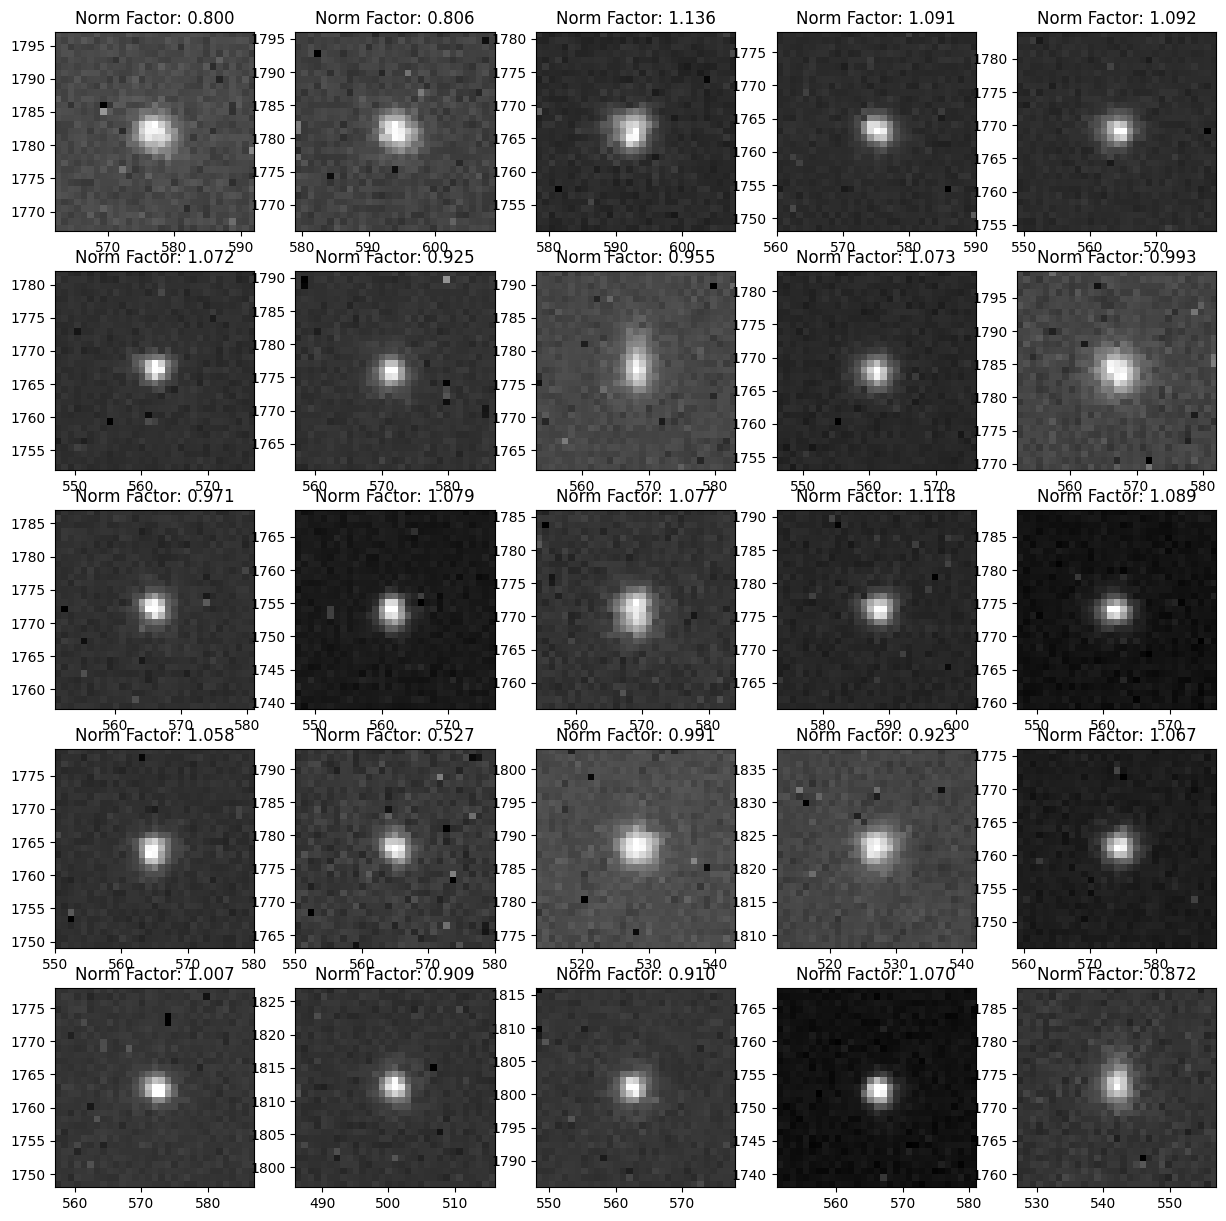

In [147]:
# using indices (keys filenames) in normcoeff_df, print the image given the index (name) in a tile plot
#use imageprocessing function defined earlier
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
def imageprocessing(arr, min_clip=-100, max_clip=5000, a=1000, contrast=3.86, bias=0.442):
    clipped = np.clip(arr, min_clip, max_clip)
    norm = (clipped - min_clip) / (max_clip - min_clip)
    log = np.log(1 + a*norm) / np.log(a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data
#we're going to do something a bit unique here.
# tile plot of 5x5 = 25, sampling random reference stars from random observation files
# select 25 random observation files from normcoeff_df index
import random
#set seed to time
random.seed()
random_files = random.sample(list(normcoeff_df.index), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

for ax, filename in zip(axes.flatten(), random_files):
    hdul = fits.open(filename)
    pixel_array = hdul['SCI'].data
    hdul.close()
    #get cutout around center of image
    # ref star index 
    ref_star_index = 13
    y_center, x_center = merged_data[filename]['image_fit']['ys_fit'][ref_star_index], merged_data[filename]['image_fit']['xs_fit'][ref_star_index]
    y_center, x_center = int(round(y_center)), int(round(x_center))
    offset = 15
    cutout = pixel_array[y_center - offset:y_center + offset + 1,
                         x_center - offset:x_center + offset + 1]
    ###
    processed_cutout = imageprocessing(cutout / normcoeff_df[filename])
    ###
    ax.imshow(processed_cutout, cmap='gray', origin='lower', extent=(x_center - offset,
                                                                     x_center + offset,
                                                                     y_center - offset,
                                                                     y_center + offset))
    #Tile label is the normalization factor
    ax.set_title(f"Norm Factor: {normcoeff_df[filename]:.3f}")
plt.show()

We save the normalization flux ratios for now and will use them later during sinusoid regression of the asteroid